This notebook trains a Vector Autoregressive Model with exogenous variables for conditional forecasting.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd
import regex

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col, new_col in zip(cols_to_keep, new_col_names)}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def split_exogenous_variables(df, dep_cols, ex_cols):
    '''
    Function to split the exogenous (independent) variables 
    from the dependent variables. Takes a dataframe as returned by
    df_long_to_wide and returns new dataframes of only the 
    dependent and exogenous variables respectively.
    
    Inputs:
        df (pd.DataFrame) :
            Wide dataframe with both dependent and exogenous variables
            as returned by the function df_long_to_wide
            
        dep_cols (list) :
            List of column names for the dependent variables without
            any coin specific suffixes (e.g. Target rather than Target_0)
            
        ex_cols (list) :
            List of column names for the exogenous variables without
            any coin specific suffixes (e.g. Open rather than Open_0)
            
    Outputs:
        dep_df (pd.DataFrame) :
            Wide dataframe with only dependent variables
    
        ex_df (pd.DataFrame) :
            Wide dataframe with only exogenous variables
    '''
    
    # make deep copy to not alter original
    df = df.copy()
    
    dep_cols = [col + "_" + str(coin) 
               for col in dep_cols 
               for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    ex_cols = [col + "_" + str(coin) 
               for col in ex_cols 
               for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    
    dep_df = df.loc[:, dep_cols]
    ex_df = df.loc[:, ex_cols]
    
    return dep_df, ex_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

dep_cols = ["Target"]
# use all variables just for demonstration
ex_cols = ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"]

df.loc[:, ex_cols] = (np.log(df.loc[:, ex_cols])).diff()

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", dep_cols + ex_cols, "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

standard_train_dep_df, standard_train_ex_df = split_exogenous_variables(standard_train_df, dep_cols, ex_cols)
standard_test_dep_df, standard_test_ex_df = split_exogenous_variables(standard_test_df, dep_cols, ex_cols)

In [5]:
del df
gc.collect()

60

In [6]:
standard_train_dep_df

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1555079640,-0.003690,-0.001787,-0.001882,-0.002293,-0.000829,-0.001438,0.002480,0.011912,-0.002559,-0.001524,-0.002951,0.027632,-0.019710,0.006126
1555079700,-0.001639,-0.001602,-0.000731,-0.001225,0.001051,-0.001777,0.003282,0.015584,-0.004204,-0.001226,-0.002924,0.000000,-0.019708,0.007576
1555079760,-0.002862,-0.000504,-0.001341,-0.002608,-0.007041,-0.001946,0.001506,0.014726,0.000026,-0.002385,-0.003826,0.026926,-0.019706,0.008655
1555079820,-0.000222,0.000566,-0.001508,-0.007047,-0.000373,-0.001211,0.000960,0.017296,-0.000975,-0.003115,-0.002333,0.002067,-0.019704,0.009373
1555079880,-0.005420,0.000000,-0.001657,-0.003066,-0.000014,-0.001697,0.000273,0.017488,-0.004186,-0.002968,-0.002824,0.027723,-0.019702,0.009369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,0.001144,0.003837,-0.001987,-0.003792,0.000378,0.000044,-0.001514,-0.013900,-0.000036,0.001576,0.010975,0.009319,0.002873,-0.001471
1624405200,0.003616,0.005019,-0.002226,-0.002935,-0.000435,0.000567,0.001226,-0.012979,-0.000741,0.002292,0.010209,0.009596,0.005023,-0.002754
1624405260,0.001411,0.005909,-0.001798,-0.001701,-0.001410,0.001436,0.001162,-0.012925,0.000537,0.003187,0.007625,0.014052,0.005137,-0.001629


In [7]:
standard_train_ex_df

,Open_2,Open_0,Open_1,Open_5,Open_7,Open_6,Open_9,Open_11,Open_13,Open_12,...,VWAP_7,VWAP_6,VWAP_9,VWAP_11,VWAP_13,VWAP_12,VWAP_3,VWAP_8,VWAP_10,VWAP_4
timestamp,,,,,,,,,,,,,,,,,,,,,
1555079640,8.126158,-2.761681,5.647873,7.568987,0.169913,3.253645,5.531586,6.359334,-8.008438,1.470061,...,0.170115,3.253630,5.530852,6.358610,-8.007866,1.470234,-6.677364,-6.263146,2.086150,-14.416605
1555079700,8.127536,-2.763214,5.648140,7.571172,0.166623,3.255850,5.557843,6.358519,-8.006713,1.468385,...,0.166752,3.255464,5.558569,6.358885,-8.006992,1.468308,-6.676574,-6.290003,2.086202,-14.417736
1555079760,8.127290,-2.762714,5.647675,7.571814,0.167025,3.254872,5.531718,6.359241,-8.004749,1.465521,...,0.166677,3.254863,5.532090,6.358646,-8.005061,1.466223,-6.675303,-6.263435,2.086254,-14.417205
1555079820,8.125712,-2.762528,5.647190,7.573413,0.166263,3.253816,5.559720,6.359336,-8.009301,1.470793,...,0.165611,3.254316,5.558016,6.358668,-8.009448,1.470944,-6.675189,-6.288872,2.086307,-14.417600
1555079880,8.124744,-2.761991,5.647709,7.572459,0.165598,3.254760,5.531832,6.357628,-8.009255,1.471217,...,0.165578,3.254872,5.531736,6.357445,-8.009222,1.471273,-6.675789,-6.261451,2.086359,-14.417529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,5.960016,-0.523648,4.825457,2.884649,2.371383,3.944903,5.150421,6.776404,-10.704148,1.520329,...,2.371391,3.944600,5.150527,6.775627,-10.705681,1.521324,-5.189557,-7.906288,2.947455,-12.057140
1624405200,5.961808,-0.524730,4.826476,2.884266,2.372855,3.943939,5.148400,6.775375,-10.705711,1.521617,...,2.373683,3.942809,5.148561,6.774128,-10.706296,1.522730,-5.189439,-7.903243,2.946913,-12.056505
1624405260,5.961169,-0.522684,4.824247,2.882942,2.372799,3.943557,5.149441,6.774027,-10.706297,1.521971,...,2.373838,3.942510,5.149203,6.774352,-10.705509,1.521674,-5.186473,-7.903876,2.946364,-12.054489


In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Train Model

In [9]:
model = VAR(endog = standard_train_dep_df, exog = standard_train_ex_df)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [10]:
fit_results = model.fit(trend = "n")

fit_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Mar, 2022
Time:                     16:33:29
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                   -172.419
Nobs:                 1.15543e+06    HQIC:                  -172.431
Log likelihood:       7.66673e+07    FPE:                1.29480e-75
AIC:                     -172.436    Det(Omega_mle):     1.29304e-75
--------------------------------------------------------------------
Results for equation Target_2
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
Open_2              -0.029126         0.002389          -12.191           0.000
Open_0              -0.012891         0.002572           -5.013           0.000
Open_1              -0.012570         0.003127           -4.0

In [11]:
# print in easier to read format
print("Absolute correlation:")
print('    '.join([str(i) for i in range(14)]))
print('\n'.join([' '.join(['{:.2f}'.format(abs(item)) for item in row]) for row in fit_results.resid_corr]))

Absolute correlation:
0    1    2    3    4    5    6    7    8    9    10    11    12    13
1.00 0.00 0.09 0.12 0.15 0.09 0.15 0.03 0.05 0.01 0.03 0.05 0.02 0.13
0.00 1.00 0.01 0.02 0.22 0.02 0.00 0.03 0.02 0.01 0.04 0.00 0.03 0.07
0.09 0.01 1.00 0.03 0.27 0.20 0.09 0.00 0.03 0.03 0.07 0.05 0.00 0.13
0.12 0.02 0.03 1.00 0.14 0.06 0.09 0.02 0.06 0.02 0.03 0.04 0.02 0.11
0.15 0.22 0.27 0.14 1.00 0.30 0.17 0.00 0.16 0.12 0.19 0.00 0.15 0.02
0.09 0.02 0.20 0.06 0.30 1.00 0.09 0.04 0.03 0.03 0.05 0.05 0.05 0.16
0.15 0.00 0.09 0.09 0.17 0.09 1.00 0.03 0.03 0.00 0.04 0.05 0.02 0.14
0.03 0.03 0.00 0.02 0.00 0.04 0.03 1.00 0.01 0.03 0.01 0.10 0.01 0.03
0.05 0.02 0.03 0.06 0.16 0.03 0.03 0.01 1.00 0.05 0.02 0.02 0.04 0.09
0.01 0.01 0.03 0.02 0.12 0.03 0.00 0.03 0.05 1.00 0.09 0.00 0.03 0.10
0.03 0.04 0.07 0.03 0.19 0.05 0.04 0.01 0.02 0.09 1.00 0.01 0.02 0.10
0.05 0.00 0.05 0.04 0.00 0.05 0.05 0.10 0.02 0.00 0.01 1.00 0.01 0.01
0.02 0.03 0.00 0.02 0.15 0.05 0.02 0.01 0.04 0.03 0.02 0.01 1.00 0.

In [12]:
print( "Percentage of non-significant coefficients: " +
    str(round(100*sum(sum(fit_results.pvalues.values > 0.05)) / fit_results.pvalues.values.size)) +
     "%")

Percentage of non-significant coefficients: 40%


Shown above, most coefficients are significant in the VAR model. There are 14 * (8 * 14) = 1568 coefficients in total. This comes from 14 equations in total with 8 * 14 coefficients for each equation.

There is also some correlation among the residuals, where certain entries have a correlation as high as ~0.30 

The fitted values can be overlaid with the original data

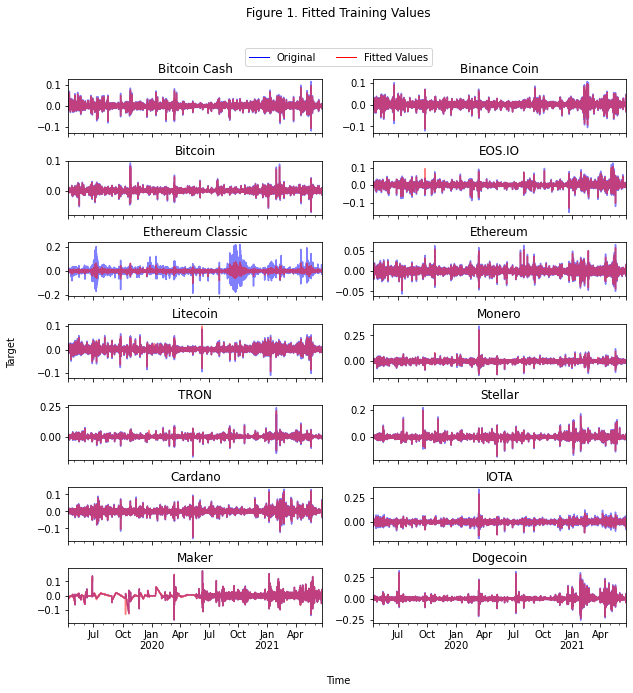

In [13]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)
temp_fit = fit_results.fittedvalues.copy()
temp_fit["timestamp"] = temp_fit.index
temp_fit.loc[:, "datetime"] = pd.to_datetime(temp_fit.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [14]:
del temp_df
del temp_fit
gc.collect()

96

## Make Forecasts and Evaluate

In [15]:
forecasts = fit_results.forecast(y = standard_train_dep_df.iloc[[-1]].values,
                                 steps = len(standard_test_df),
                                 exog_future = standard_test_ex_df)

In [16]:
forecasts

array([[ 3.20483807e-03,  1.41326732e-02, -2.62746685e-03, ...,
         1.44374735e-02,  1.40831376e-02, -6.40369545e-03],
       [ 3.01058287e-03,  1.28739493e-02, -2.23797111e-03, ...,
         1.08103803e-02,  1.37051756e-02, -6.00707191e-03],
       [ 2.76673176e-03,  1.17077316e-02, -2.04980451e-03, ...,
         9.45767499e-03,  1.35278150e-02, -5.29023124e-03],
       ...,
       [ 1.44445603e-04,  3.94229718e-04, -7.58446647e-05, ...,
        -2.48063344e-04, -6.90939377e-04,  3.83691088e-04],
       [ 1.46579713e-04,  3.49516200e-04, -9.76213402e-05, ...,
        -7.87664907e-05, -6.41921636e-04,  4.31839648e-04],
       [ 1.60746572e-04,  3.67427021e-04, -1.24537438e-04, ...,
         1.79397987e-05, -5.55222957e-04,  4.16743968e-04]])

In [17]:
forecast_df = pd.DataFrame(data = forecasts, columns = standard_test_dep_df.columns)

forecast_df

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
0,0.003205,0.014133,-0.002627,-0.000115,0.002461,0.001490,0.001909,-0.005113,0.001998,0.003987,0.005446,0.014437,0.014083,-0.006404
1,0.003011,0.012874,-0.002238,0.000049,0.002881,0.001523,0.001577,-0.004386,0.001703,0.003552,0.004740,0.010810,0.013705,-0.006007
2,0.002767,0.011708,-0.002050,0.000078,0.003227,0.001313,0.001269,-0.003123,0.001521,0.003522,0.004587,0.009458,0.013528,-0.005290
3,0.002490,0.010910,-0.001827,0.000084,0.003129,0.001207,0.001106,-0.002295,0.001280,0.003295,0.004181,0.008199,0.013293,-0.004820
4,0.002323,0.009872,-0.001664,0.000193,0.002951,0.001075,0.000959,-0.001522,0.001283,0.003312,0.004004,0.007194,0.013110,-0.004310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129596,0.000133,0.000389,-0.000065,0.000386,-0.000722,-0.000165,0.000087,-0.000137,-0.000044,-0.000440,-0.000452,-0.000387,-0.000674,0.000321
129597,0.000148,0.000437,-0.000094,0.000303,-0.000607,-0.000179,0.000131,-0.000126,-0.000051,-0.000423,-0.000447,-0.000254,-0.000704,0.000420
129598,0.000144,0.000394,-0.000076,0.000326,-0.000596,-0.000186,0.000140,-0.000066,-0.000171,-0.000389,-0.000467,-0.000248,-0.000691,0.000384
129599,0.000147,0.000350,-0.000098,0.000263,-0.000692,-0.000159,0.000090,0.000012,-0.000155,-0.000307,-0.000365,-0.000079,-0.000642,0.000432


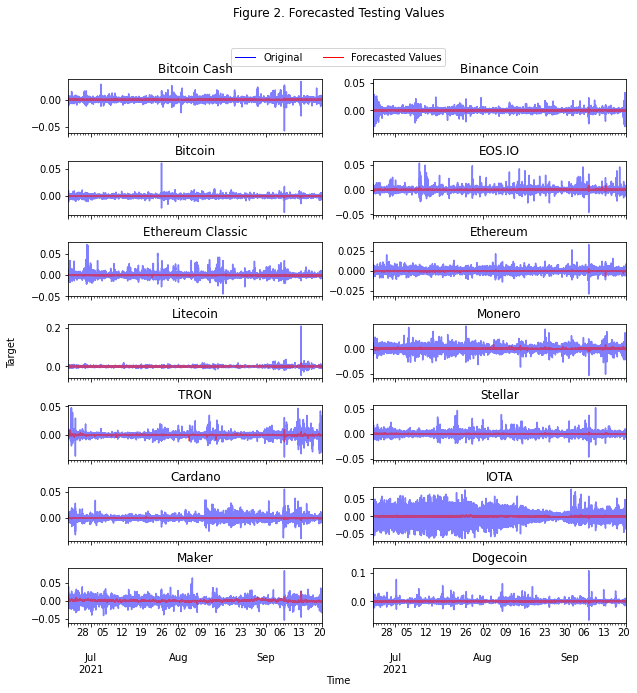

In [18]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [19]:
del temp_df
del temp_fit
gc.collect()

58806

## Evaluated VARX Assumptions i.e. Granger Causality

The use of exogenous variables in an autoregressive model brings additional [assumptions](https://www.personal.psu.edu/hxb11/EasyRegTours/VAR_Tourfiles/VARX.PDF). Namely, the dependent variables should not Granger cause any of the exogenous variables.

For simplicity, only the first and fifteenth lags will be evaluated and only with one coin. This is because only the first lag is used in the VARX model, making it the mathematically important. The fifteenth lag is related to how Target is calculated, being a 15 minute return on investment, and so has conceptual importance that may be related to Granger causality. Finally, only one coin is checked under the assumption that if these variables are Granger causal then it would be present for every coin to about the same degree. This is because each of the variables for a given coin is defined the same way as for other coins. For brevity, therefore, only one is examined.

In [20]:
# get every dependent to exogenous variable pair
for col in standard_train_dep_df.columns:
    
    for ex_col in standard_train_ex_df.columns:
        
        # check if coin is the same for the two columns
        # as this case would have strongest chance of rejecting
        if (col[col.find("_")+1:] == ex_col[ex_col.find("_")+1:]):
        
            print("\nFor outcome " + str(col) + " and exogenous " +
                 str(ex_col) + ":")
            temp_df = pd.DataFrame(data = [
                standard_train_ex_df.loc[:, ex_col],
                standard_train_dep_df.loc[:, col]
                                          ]).T
            grangercausalitytests(x = temp_df, maxlag = [1, 15], addconst = True)
        
            del temp_df
            
        gc.collect()
       
    # only check first coin
    break


For outcome Target_2 and exogenous Open_2:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0070  , p=0.9334  , df_denom=1155426, df_num=1
ssr based chi2 test:   chi2=0.0070  , p=0.9334  , df=1
likelihood ratio test: chi2=0.0070  , p=0.9334  , df=1
parameter F test:         F=0.0070  , p=0.9334  , df_denom=1155426, df_num=1

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=0.9265  , p=0.5333  , df_denom=1155384, df_num=15
ssr based chi2 test:   chi2=13.8975 , p=0.5333  , df=15
likelihood ratio test: chi2=13.8975 , p=0.5333  , df=15
parameter F test:         F=0.9265  , p=0.5333  , df_denom=1155384, df_num=15

For outcome Target_2 and exogenous Close_2:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0113  , p=0.9154  , df_denom=1155426, df_num=1
ssr based chi2 test:   chi2=0.0113  , p=0.9154  , df=1
likelihood ratio test: chi2=0.0113  , p=0.9154  , df=1
parameter F test:         F=0.0113  , p=0.9154  , df_

Shown above, all major cases reject the Granger causality tests. This makes it difficult to establish that the exogenous variables are truly important for forecasting the independent variable, and not a case of spurious correlation. Therefore, added detail should be paid towards the choise of exogenous variables used and evaluation scores against the three month test period.